**Project-1**

Data Set - http://www.stat.ufl.edu/~winner/data/airq402.dat

Data Description - http://www.stat.ufl.edu/~winner/data/airq402.txt

Assignment Expectations/Steps -

1. Import and store the data in a data frame. (2.5 points)
2. Remove the outliers from the data (5 points)
3. Treat “Average Fare” – 3rdColumn as your Dependent Variable and Rest of the columns as Independent Variable. (2.5 points)
4. Drop the independent variables which has less than 0.1 correlation with the dependent variable (5 points)
5. Create scatter Plot of Independent Variable vs Dependent Variable. (2.5 points)
6. Divide the data set into training and test data set and build a Multiple Linear Regression model. (5 points)
7. Print the coefficients & intercepts of the linear regression model (5 points)
8. Print the accuracy of the overall model (2.5 points)


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

**1. Import and store the data in a data frame.**

In [0]:
# Assign new, compressed names to the columns 
cols=['cityFrom','cityTo','avgFare','distance','avgWeekPsgrs',
          'mktLeadArLn','mktShare','avgFareLead','lowPriceArLn','mktShareLow','price'] 

#df = pd.read_fwf('airq402.dat', names=colnames)
df = pd.read_fwf('http://users.stat.ufl.edu/~winner/data/airq402.dat', names=cols)
df.head()

,cityFrom,cityTo,avgFare,distance,avgWeekPsgrs,mktLeadArLn,mktShare,avgFareLead,lowPriceArLn,mktShareLow,price
0,CAK,ATL,114.47,528,424.56,FL,70.19,111.03,FL,70.19,111.03
1,CAK,MCO,122.47,860,276.84,FL,75.10,123.09,DL,17.23,118.94
2,ALB,ATL,214.42,852,215.76,DL,78.89,223.98,CO,2.77,167.12
3,ALB,BWI,69.40,288,606.84,WN,96.97,68.86,WN,96.97,68.86
4,ALB,ORD,158.13,723,313.04,UA,39.79,161.36,WN,15.34,145.42


**Exploratory Data Analysis**

In [0]:
print(df.isnull().values.any())
#The dataset has no missing values and 4 columns with object values,, these could be treated as categorical, but they do have a high cardinality. the data is clean enough for immediate analysis.


False


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
cityFrom        1000 non-null object
cityTo          1000 non-null object
avgFare         1000 non-null float64
distance        1000 non-null int64
avgWeekPsgrs    1000 non-null float64
mktLeadArLn     1000 non-null object
mktShare        1000 non-null float64
avgFareLead     1000 non-null float64
lowPriceArLn    1000 non-null object
mktShareLow     1000 non-null float64
price           1000 non-null float64
dtypes: float64(6), int64(1), object(4)
memory usage: 86.0+ KB


In [0]:
df.select_dtypes(include=['object']).nunique()


cityFrom        90
cityTo          85
mktLeadArLn     16
lowPriceArLn    19
dtype: int64

In [0]:
cityStack = df.cityFrom.append(df.cityTo)
airlnStack = df.mktLeadArLn.append(df.lowPriceArLn)
print('unique locations: {} | unique airlines: {}'.format(cityStack.nunique(), airlnStack.nunique()))

unique locations: 104 | unique airlines: 19


In [0]:
#What can be experimented with is a simple categorical encoding, wherein each unique entry is assigned it's own number. Pandas does with relative ease by assigning desired object columns to a category dtype.
cats = ['cityFrom','cityTo','mktLeadArLn','lowPriceArLn']
df[cats] = df[cats].astype('category')
df.head()


,cityFrom,cityTo,avgFare,distance,avgWeekPsgrs,mktLeadArLn,mktShare,avgFareLead,lowPriceArLn,mktShareLow,price
0,CAK,ATL,114.47,528,424.56,FL,70.19,111.03,FL,70.19,111.03
1,CAK,MCO,122.47,860,276.84,FL,75.10,123.09,DL,17.23,118.94
2,ALB,ATL,214.42,852,215.76,DL,78.89,223.98,CO,2.77,167.12
3,ALB,BWI,69.40,288,606.84,WN,96.97,68.86,WN,96.97,68.86
4,ALB,ORD,158.13,723,313.04,UA,39.79,161.36,WN,15.34,145.42


In [0]:
df.dtypes

cityFrom        category
cityTo          category
avgFare          float64
distance           int64
avgWeekPsgrs     float64
mktLeadArLn     category
mktShare         float64
avgFareLead      float64
lowPriceArLn    category
mktShareLow      float64
price            float64
dtype: object

In [0]:
#In order to actually use the numeric representation, we need to get the underlying cat.codes from pandas. Note the .name in the equivalence check, because of the way pandas handles categorical dtypes, simply comparing like one would with a float or int does not work.
df = df.apply(lambda x: x.cat.codes if x.dtype.name == 'category' else x)
df.head()

,cityFrom,cityTo,avgFare,distance,avgWeekPsgrs,mktLeadArLn,mktShare,avgFareLead,lowPriceArLn,mktShareLow,price
0,16,0,114.47,528,424.56,6,70.19,111.03,8,70.19,111.03
1,16,40,122.47,860,276.84,6,75.10,123.09,6,17.23,118.94
2,2,0,214.42,852,215.76,4,78.89,223.98,5,2.77,167.12
3,2,7,69.40,288,606.84,14,96.97,68.86,17,96.97,68.86
4,2,52,158.13,723,313.04,12,39.79,161.36,17,15.34,145.42


 **2.Remove the outliers from the data**

In [0]:
#calculating the IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)
#print the df before exoluding the outlier
print(df.shape)
df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
#print the df before after the outlier
print(df_out.shape)

avgFare          71.4175
distance        899.0000
avgWeekPsgrs    512.7150
mktShare         27.0000
avgFareLead      78.8925
mktShareLow      39.7775
price            54.7625
dtype: float64
(1000, 11)
(885, 11)


**3. Treat “Average Fare” – 3rdColumn as your Dependent Variable and Rest of the columns as Independent Variable.**

**=====I have done the same execrise in step 6.====**

**4. Drop the independent variables which has less than 0.1 correlation with the dependent variable**

In [0]:
df.corr()
#there are cityFrom,cityTo,avgWeekPsgrs,mktLeadArLn,mktShare,lowPriceArLn,mktShareLow are not tightly corelated with target varibale(avgFare), removing the same
df.drop(['cityFrom','cityTo','avgWeekPsgrs','mktLeadArLn','mktShare','lowPriceArLn','lowPriceArLn','mktShareLow'], axis=1, inplace=True)
df.head()

,avgFare,distance,avgFareLead,price
0,114.47,528,111.03,111.03
1,122.47,860,123.09,118.94
2,214.42,852,223.98,167.12
3,69.40,288,68.86,68.86
4,158.13,723,161.36,145.42


**5. Create scatter Plot of Independent Variable vs Dependent Variable.** 

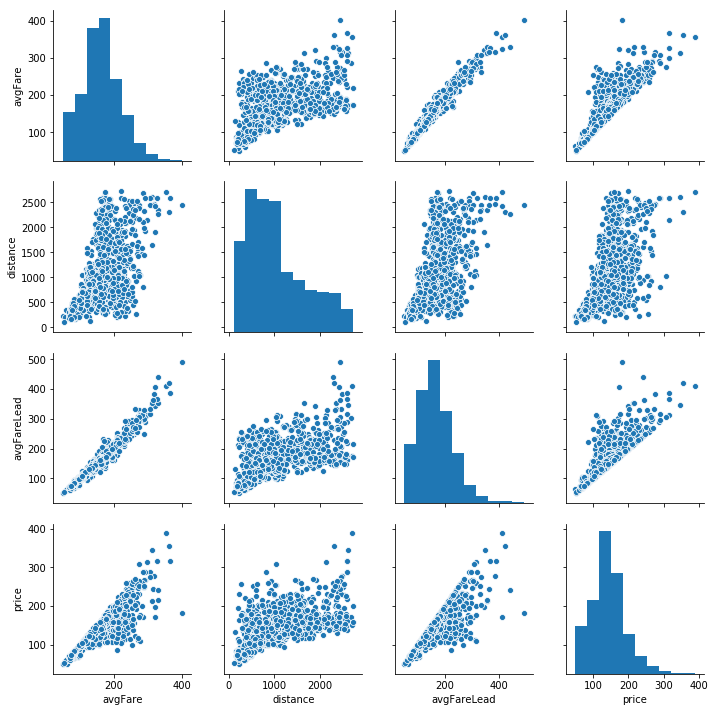

In [0]:
sns.pairplot(df)

**6. Divide the data set into training and test data set and build a Multiple Linear Regression model.**

In [0]:
from sklearn.linear_model import LinearRegression
x = df.drop(['avgFare'], axis=1)

y = df[['avgFare']]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
y_train = y_train.values.ravel()

regressor = LinearRegression()
model = regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print(y_pred)

[111.4775088  188.28132609 171.52125184 229.40564722 236.96570567
 116.04528994 186.26949058 109.241131   142.37481857 138.08442651
 178.38256747 231.11136286 144.72242786  86.32664677 102.97735587
 125.56457699 139.83148906 153.0289888  215.80200427  86.14716129
 125.42868461 148.97911943 166.21743831 231.18147803 178.72088731
 124.63957342 130.28179057 143.53191155 137.32476346 145.32010943
 114.22727777 157.76676896 152.81183041 220.24928765 110.91871348
  92.31541314 121.60383672  76.16139171  80.53214921  91.65407819
 102.07631881 107.15337032 131.89420999 157.41713114 132.04862576
  85.3985872  177.03959826 194.65742867 266.17820884 135.9532829
 185.33287174 228.8620569  215.2835798  152.70221997 182.27408974
 224.58452854 152.88568171  75.67624517 129.00474153  91.8574831
 208.26008277 150.05889977 251.03142857 137.79768532 192.34317707
 166.96892231 200.31885261 165.5009478  129.81637586 133.74710176
 315.43746481 111.6375333  137.88178409  79.63673968 142.57208944
 225.2158674

**7. Print the coefficients & intercepts of the linear regression model**



In [0]:
r_sq = model.score(X_train, y_train)
print('coefficient of determination:', r_sq)
print('intercept:', model.intercept_)
print('slope:', model.coef_)


coefficient of determination: 0.9727704708097619
intercept: 11.725921665575669
slope: [0.00157137 0.72778308 0.19951958]


**8. Print the accuracy of the overall model**

In [0]:
# show accuracy
from sklearn.metrics import r2_score
r2 = regressor.score(X_train, y_train)

# adjusted r2 using formula adj_r2 = 1 - (1- r2) * (n-1) / (n - k - 1)
# k = number of predictors = X_train_scaled.shape[1] - 1
adj_r2 = 1 - (1-r2)*(len(X_train) - 1) / (len(X_train) - (X_train.shape[1] - 1) - 1)
print(r2, adj_r2)

0.9727704708097619 0.9727021407490586
